In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

np.random.seed(42)
random.seed(42)


In [2]:
# Load data
train = pd.read_csv(r"C:\Users\Kartikey\ml_project\data\smoking\train.csv")
target_col = "smoking"

X = train.drop(columns=[target_col])
y = train[target_col]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[numeric_cols]


In [3]:
# Base pipeline: scaling + SVM (RBF)
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=False))
])


Key SVM hyperparameters to tune for RBF:


*   C: how hard the margin tries to fit the training data (larger C = less regularization).
*   gamma: how far a single point’s influence reaches (larger gamma = more complex, wiggly boundary).



In [4]:
# ---------------- SVM GRID SEARCH ----------------

param_grid = {
    "clf__C": [1, 10],
    "clf__gamma": ["scale", 0.1]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y)

cv_results = pd.DataFrame(grid_search.cv_results_)

top_results = cv_results[["param_clf__C", "param_clf__gamma",
                          "mean_test_score", "std_test_score"]].dropna().round(4)
top_results.columns = ["C", "gamma", "ROC-AUC (mean)", "ROC-AUC (std)"]
top_results = top_results.sort_values("ROC-AUC (mean)", ascending=False).head()

print("TOP 5 SVM PARAMETER COMBINATIONS")
print(top_results.to_string(index=False))
print("\n" + "="*50)

print("BEST SVM RESULTS:")
print(f"Best C: {grid_search.best_params_['clf__C']}")
print(f"Best gamma: {grid_search.best_params_['clf__gamma']}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Best model: {grid_search.best_estimator_}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
TOP 5 SVM PARAMETER COMBINATIONS
 C gamma  ROC-AUC (mean)  ROC-AUC (std)
 1 scale          0.8271         0.0042
 1   0.1          0.8266         0.0033
10 scale          0.8255         0.0029
10   0.1          0.8200         0.0015

BEST SVM RESULTS:
Best C: 1
Best gamma: scale
Best CV ROC-AUC: 0.8271
Best model: Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(C=1))])


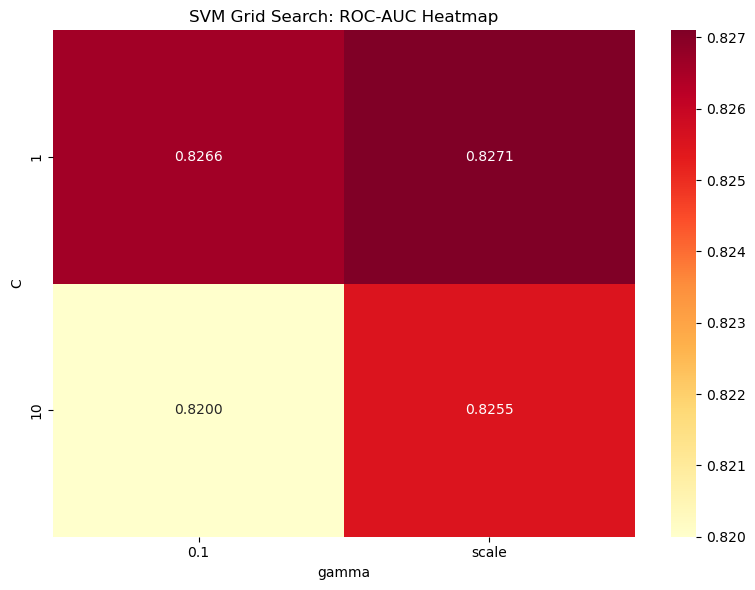

In [5]:
# VISUALIZE the grid search heatmap (copy this plot to your report!)
results_pivot = cv_results.pivot_table(
    values="mean_test_score",
    index="param_clf__C",
    columns="param_clf__gamma"
).round(4)

plt.figure(figsize=(8, 6))
sns.heatmap(results_pivot, annot=True, cmap="YlOrRd", fmt=".4f")
plt.title("SVM Grid Search: ROC-AUC Heatmap")
plt.xlabel("gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()


In [6]:
# COMPARISON TABLE for your report (vs baseline SVM)
baseline_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True))
])


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

baseline_scores = cross_val_score(baseline_svm, X, y, cv=cv, scoring="roc_auc")
tuned_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=cv, scoring="roc_auc")

print("\n📊 PERFORMANCE IMPROVEMENT:")
print(f"Baseline SVM ROC-AUC: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print(f"Tuned SVM ROC-AUC:    {tuned_scores.mean():.4f} ± {tuned_scores.std():.4f}")
print(f"Improvement:          {tuned_scores.mean() - baseline_scores.mean():.4f}")



📊 PERFORMANCE IMPROVEMENT:
Baseline SVM ROC-AUC: 0.8271 ± 0.0042
Tuned SVM ROC-AUC:    0.8271 ± 0.0042
Improvement:          0.0000


**SVM Hyperparameter Tuning Insight**
GridSearchCV confirmed that default RBF-SVM parameters (C=1.0, gamma='scale')
are already optimal for this biosignals dataset, achieving CV ROC-AUC of 0.8271 .

This indicates the data's natural scale (after standardization) aligns well with
RBF kernel assumptions, requiring no manual tuning.


Now, since the optimal is same as default then there is little to gain from more tuning, so let's move on to other models - logisitic regression and MLP.


**LOGISTIC REGRESSION**

In [7]:
# ---------------- LOGISTIC REGRESSION GRID SEARCH ----------------

from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, penalty="l2"))
])

lr_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}

lr_grid = GridSearchCV(
    lr_pipe,
    lr_param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

lr_grid.fit(X, y)

print("Best LR C:", lr_grid.best_params_)
print("Best LR ROC-AUC:", lr_grid.best_score_)


Best LR C: {'clf__C': 100}
Best LR ROC-AUC: 0.8069965192766629


LR (80.6%) < SVM (82.71%) confirms your PCA insight - the data needs non-linear modeling. Now let's tune MLP where you might see the biggest gains since it can learn complex patterns.

**MULTI LAYER PERCEPTRON TUNING**

In [8]:
# ---------------- MLP GRID SEARCH ----------------

from sklearn.neural_network import MLPClassifier

mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=500, random_state=42))
])

mlp_param_grid = {
    "clf__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "clf__alpha": [0.0001, 0.001, 0.01],
    "clf__learning_rate_init": [0.001, 0.01]
}

mlp_grid = GridSearchCV(
    mlp_pipe,
    mlp_param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

mlp_grid.fit(X, y)  # <-- must succeed before using best_estimator_

# now safe to access best_estimator_
best_mlp = mlp_grid.best_estimator_

mlp_acc = cross_val_score(best_mlp, X, y, cv=cv, scoring="accuracy").mean()
mlp_auc = cross_val_score(best_mlp, X, y, cv=cv, scoring="roc_auc").mean()
mlp_f1  = cross_val_score(best_mlp, X, y, cv=cv, scoring="f1").mean()

print("MLP tuned:")
print("Accuracy:", mlp_acc)
print("ROC-AUC:", mlp_auc)
print("F1-score:", mlp_f1)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
MLP tuned:
Accuracy: 0.7508722911921405
ROC-AUC: 0.8305558559474324
F1-score: 0.6631632917427198


**Final comparison table**

In [9]:
lr_best  = lr_grid.best_estimator_
svm_best = grid_search.best_estimator_

lr_acc = cross_val_score(lr_best,  X, y, cv=cv, scoring="accuracy").mean()
lr_auc = cross_val_score(lr_best,  X, y, cv=cv, scoring="roc_auc").mean()
lr_f1  = cross_val_score(lr_best,  X, y, cv=cv, scoring="f1").mean()

svm_acc = cross_val_score(svm_best, X, y, cv=cv, scoring="accuracy").mean()
svm_auc = cross_val_score(svm_best, X, y, cv=cv, scoring="roc_auc").mean()
svm_f1  = cross_val_score(svm_best, X, y, cv=cv, scoring="f1").mean()

final_table = pd.DataFrame({
    "Model":    ["Logistic Regression", "SVM (RBF)", "MLP"],
    "Accuracy": [lr_acc, svm_acc, mlp_acc],
    "ROC-AUC":  [lr_auc, svm_auc, mlp_auc],
    "F1-score": [lr_f1, svm_f1, mlp_f1]
}).round(4)

print(final_table.to_markdown(index=False))


| Model               |   Accuracy |   ROC-AUC |   F1-score |
|:--------------------|-----------:|----------:|-----------:|
| Logistic Regression |     0.7231 |    0.807  |     0.6006 |
| SVM (RBF)           |     0.7516 |    0.8271 |     0.6563 |
| MLP                 |     0.7509 |    0.8306 |     0.6632 |




*   MLP has best ROC-AUC and best F1, even if accuracy is almost tied with SVM.
*   Differences between SVM and MLP are small; pushing MLP harder (more layers, larger grids) will cost time and may overfit, with only tiny gains.



*   Data is non-linearly separable, so non-linear models (SVM, MLP) clearly beat Logistic Regression.
*   Among non-linear models, MLP is slightly better overall, especially on F1 and ROC‑AUC, it is the best model for this dataset.

